# **classification for GURU2 Android Application**
* **GURU2 프로젝트 - 스마트 채소 품질 체크 어플리케이션**
 * 카메라 + 인공지능 딥러닝 모델 구현
* https://www.notion.so/7swuguru2/f3d0c13c9baa45d5ad9c2fe7c2fccca7?pvs=4 해당 노션에서 데이터 준비 및 라벨링 단계 과정을 보실 수 있습니다.
* 모델 학습 이후 tflite 파일로 전환하여 android studio에 적용해, 앱 개발을 진행했습니다.
* by Seoyeon Sunny Oh

## 작업 순서
* 데이터 불러오기
* 이미지 전처리
* 베이스라인 모델 설정
* 모델 튜닝 후 성능 높이기
 * 데이터 증강
 * 전이 학습
* 모델 성능 확인
* 결론

In [1]:
# Google Colab Pro

# 더 빠른 GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Jul  7 15:41:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.metrics import classification_report, accuracy_score

## 데이터 불러오기(드라이브 마운트)
* 데이터가 너무 커서 구글 드라이브에 미리 zip파일로 업로드함
* 따라서, 코랩에서 진행할 수 있도록 드라이브 마운트 진행

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* 해당 파일은 zip 파일이어서 파일을 해체시키는 작업 필요

In [ ]:
# colab에서는 이렇게 진행
# %cd /content/drive/MyDrive/생활속인공지능실습
# !unzip -qq "/content/drive/MyDrive/생활속인공지능실습/dataset.zip"

/content/drive/MyDrive/생활속인공지능실습


### 이미지 경로를 데이터 프레임 형태로 만드는 함수
* 데이터셋 자체가 애초에 Test와 Train으로 나뉘어져 있었기 때문에, 각자 train_df와 test_df를 따로 불러와줄 것
* 이미지 데이터 Train, Test 데이터로 분류(train_test_split)할 필요가 없음!

In [2]:
train_dir_ = Path('G:/내 드라이브/생활속인공지능실습/dataset/Train')
train_filepaths = list(train_dir_.glob('**/*.jpg')) + list(train_dir_.glob('**/*.png'))
# jpg와 png 파일이 함께 있는 경우가 많아 +로 묶어서 진행
## path.glob 함수 (https://m.blog.naver.com/siniphia/221397012627)

test_dir_ = Path('G:/내 드라이브/생활속인공지능실습/dataset/Test')
test_filepaths = list(test_dir_.glob('**/*.jpg')) + list(test_dir_.glob('**/*.png'))
# jpg와 png 파일이 함께 있는 경우가 많아 +로 묶어서 진행


# 함수 정의
def proc_img(filepaths):
    labels = [Path(filepath).parent.name for filepath in filepaths]

    filepath = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df


train_df = proc_img(train_filepaths)
train_df.head(5)

,Filepath,Label
0,G:\내 드라이브\생활속인공지능실습\dataset\Train\freshtomato\...,freshtomato
1,G:\내 드라이브\생활속인공지능실습\dataset\Train\rottentomato...,rottentomato
2,G:\내 드라이브\생활속인공지능실습\dataset\Train\rottenbanana...,rottenbanana
3,G:\내 드라이브\생활속인공지능실습\dataset\Train\rottencucumb...,rottencucumber
4,G:\내 드라이브\생활속인공지능실습\dataset\Train\freshpotato\...,freshpotato


In [3]:
test_df = proc_img(test_filepaths)
test_df.head(5)

,Filepath,Label
0,G:\내 드라이브\생활속인공지능실습\dataset\Test\rottencucumbe...,rottencucumber
1,G:\내 드라이브\생활속인공지능실습\dataset\Test\rottenbanana\...,rottenbanana
2,G:\내 드라이브\생활속인공지능실습\dataset\Test\freshbanana\b...,freshbanana
3,G:\내 드라이브\생활속인공지능실습\dataset\Test\rottenpotato\...,rottenpotato
4,G:\내 드라이브\생활속인공지능실습\dataset\Test\freshbanana\b...,freshbanana


In [4]:
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')  # 종류(유일 값) 자체 개수 세기
print(f'Labels: {train_df.Label.unique()}') # 종류(유일 값) 출력

Number of pictures: 20071

Number of different labels: 12

Labels: ['freshtomato' 'rottentomato' 'rottenbanana' 'rottencucumber'
 'freshpotato' 'freshbanana' 'rottenapples' 'rottenoranges' 'freshapples'
 'rottenpotato' 'freshoranges' 'freshcucumber']


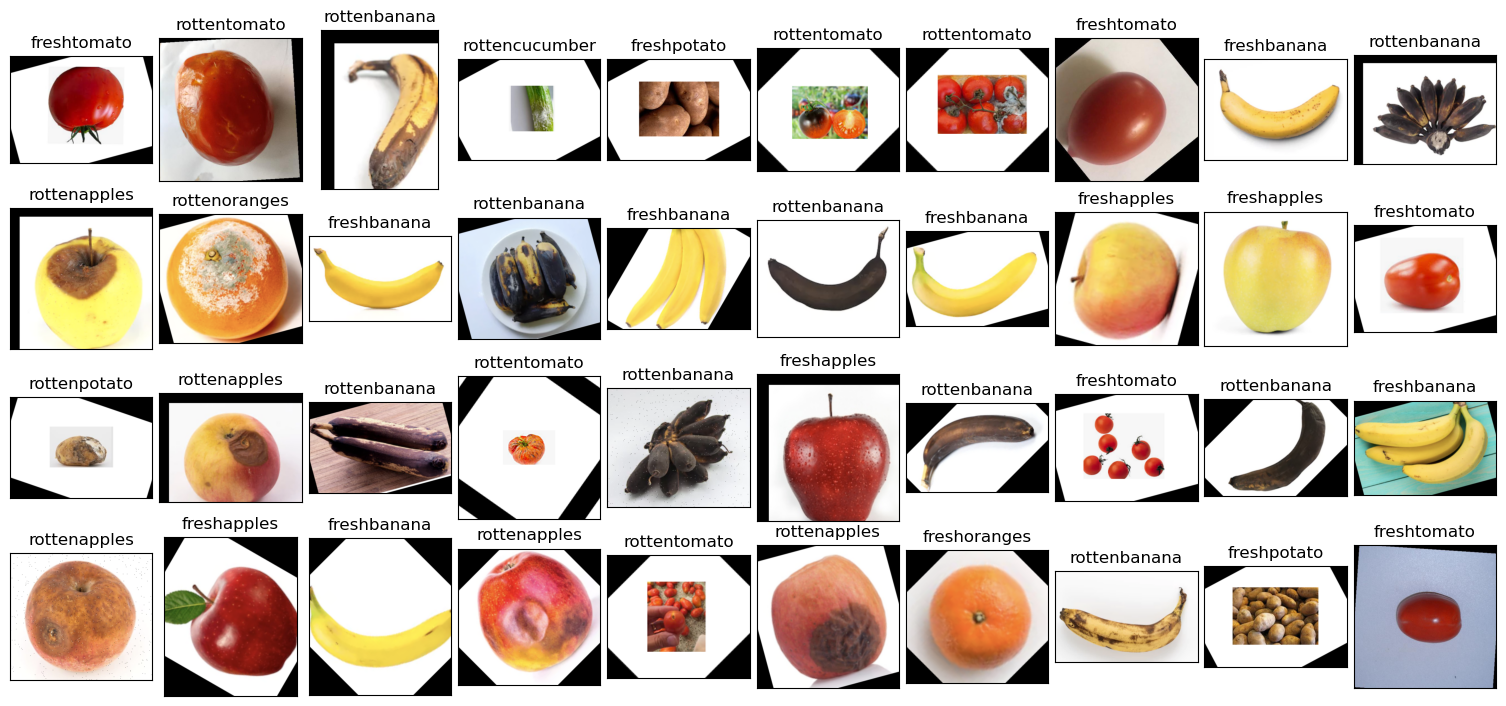

In [8]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## Label Category 분포 확인

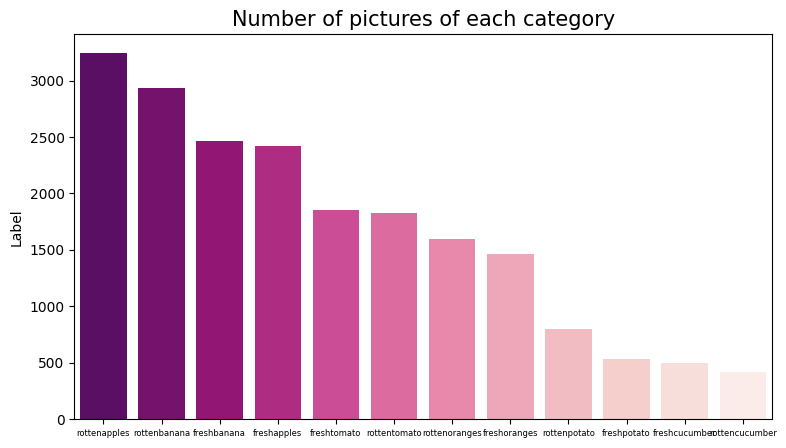

In [ ]:
vc = train_df['Label'].value_counts()   # 종류 별로 몇 개 (유일한 값별로 개수) 인지 세기
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "RdPu_r")
plt.xticks(fontsize=6)
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

## **베이스 라인 모델**
## 모델 전처리

In [5]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(train_dir_, target_size = (150, 150), batch_size = 64,
                                              class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory(train_dir_, target_size = (150, 150), batch_size = 64,
                                              class_mode = 'categorical',subset='validation')

Found 16061 images belonging to 12 classes.
Found 4010 images belonging to 12 classes.


## 딥러닝 CNN모델로 베이스라인 모델링

In [6]:
# CNN Sequential 모델 초기화
## Sequential 모델; 여러 레이어를 선형으로 쌓아 구성할 수 있는 모델
cnn = tf.keras.models.Sequential()


# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
## tf.keras.layers.Conv2D(): 2D Convolutional 레이어를 추가
## 이미지의 특징을 추출하기 위해 컨볼루션 작업을 수행

### filters=32: 32개의 필터를 사용하여 특징을 추출
### kernel_size=3: 3x3 크기의 필터를 사용
### input_shape=[150, 150, 3]: 입력 이미지의 크기를 지정

In [7]:
# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
## tf.keras.layers.MaxPool2D(): Max Pooling 레이어를 추가
## 특징 맵의 크기를 줄이고 중요한 정보를 보존

### pool_size=2: 2x2 크기의 풀링 필터를 사용
### strides=2: 풀링 작업을 2 스텝씩 수행하여 특징 맵의 크기를 줄임


# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
## 이전과 동일한 방식으로 추가적인 Convolutional 레이어와 Max Pooling 레이어를 추가
## 이렇게 해주면 모델은 더욱 복잡한 특징을 학습할 수 있음!

In [8]:
# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())
## tf.keras.layers.Flatten(): 2D 특징 맵을 1D로 변환하는 레이어
## 이전 레이어에서 생성된 특징 맵을 1차원 벡터로 펼쳐서 Fully Connected Layer에 전달


# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
## tf.keras.layers.Dense(): 전결합층 (Fully Connected Layer)을 추가
## 이 층은 특징 맵의 정보를 활용하여 분류를 수행
### units=128: 128개의 뉴런을 가진 층을 추가


# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=12, activation='softmax'))
## tf.keras.layers.Dense(): 출력층을 추가
## units=12: 12개의 클래스를 분류하는 문제를 다루기 때문에 12개의 뉴런을 가진 층을 추가
## activation='softmax': Softmax 활성화 함수를 사용하여 다중 클래스 분류를 수행

In [9]:
# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
  ## optimizer='adam': Adam optimizer를 사용하여 모델을 최적화
  ## loss='categorical_crossentropy': categorical cross-entropy 손실 함수를 사용하여 모델의 오차를 계산
  ## metrics=['accuracy']: 모델의 성능을 평가하기 위해 정확도를 사용
cnn.summary()
  ## cnn.summary(): 모델의 요약 정보를 출력
  ## 이를 통해 각 레이어의 구성과 파라미터 개수 등을 확인할 수 있음

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

## 모델 성능 확인(accuracy)

In [15]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs=10)

Epoch 1/10
251/251 [==============================] - 16052s 64s/step - loss: 0.8036 - accuracy: 0.7232 - val_loss: 0.8171 - val_accuracy: 0.6800
Epoch 2/10
251/251 [==============================] - 203s 810ms/step - loss: 0.3077 - accuracy: 0.8933 - val_loss: 0.6401 - val_accuracy: 0.7559
Epoch 3/10
251/251 [==============================] - 204s 813ms/step - loss: 0.1916 - accuracy: 0.9306 - val_loss: 0.7337 - val_accuracy: 0.7621
Epoch 4/10
251/251 [==============================] - 205s 818ms/step - loss: 0.1315 - accuracy: 0.9549 - val_loss: 0.7210 - val_accuracy: 0.7748
Epoch 5/10
251/251 [==============================] - 205s 817ms/step - loss: 0.0837 - accuracy: 0.9706 - val_loss: 0.7391 - val_accuracy: 0.7800
Epoch 6/10
251/251 [==============================] - 204s 812ms/step - loss: 0.0600 - accuracy: 0.9791 - val_loss: 0.6676 - val_accuracy: 0.8085
Epoch 7/10
251/251 [==============================] - 204s 812ms/step - loss: 0.0436 - accuracy: 0.9849 - val_loss: 0.6714 -

* accuracy = 0.9859
* val_accuracy = 0.8209
로 아직 전이학습 진행하지 않았음에도 꽤 높은 성능을 보이고 있음을 확인할 수 있음

In [18]:
# 너무 오래 걸려서, 딥러닝 모델을 저장하는 함수 적용
savemodel_path = 'C:/Users/sohtk/OneDrive/desktop/2023summer/GURU2 Android/final_project/cnn_model_1.h5'
cnn.save(savemodel_path)
print("모델이 저장된 경로:", savemodel_path)

모델이 저장된 경로: C:/Users/sohtk/OneDrive/desktop/2023summer/GURU2 Android/final_project/cnn_model_1.h5


In [10]:
from tensorflow.keras.models import load_model
cnn = load_model('cnn_model_1.h5')

## 모델 성능 높이기

## 데이터 증감

In [5]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방향의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

## 전이학습 사용해서 모델 성능 높이기

In [12]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

## 함수 내부에서는 전이 학습을 위해 사전 훈련된 모델을 로드하고, 추가적인 레이어를 연결하여 모델 구조를 정의
## 모델의 학습 가능한 가중치는 동결시키고, 컴파일 단계에서 옵티마이저, 손실 함수, 평가 지표를 설정.


def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs) # 모델마다 차례로 넣는다는 의미
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
    # 라벨 개수가 12개이기 때문에 Dense도 12로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Found 18064 validated image filenames belonging to 12 classes.
Found 2007 validated image filenames belonging to 12 classes.
Found 6144 validated image filenames belonging to 12 classes.




In [13]:
# Train 모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

29084464/29084464 [==============================] - 2s 0us/step
DenseNet121          trained in 692.23 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 343.97 sec
74836368/74836368 [==============================] - 3s 0us/step
DenseNet201          trained in 870.81 sec
16705208/16705208 [==============================] - 2s 0us/step
EfficientNetB0       trained in 412.92 sec
27018416/27018416 [==============================] - 2s 0us/step
EfficientNetB1       trained in 512.69 sec
87910968/87910968 [==============================] - 4s 0us/step
InceptionV3          trained in 395.83 sec
12683000/12683000 [==============================] - 1s 0us/step
MobileNetV3Large     trained in 336.35 sec
234545216/234545216 [==============================] - 9s 0us/step
ResNet152V2          trained in 1299.66 sec
94765736/94765736 [==============================] - 5s 0us/step
ResNet50             trained in 681.77 sec
94668760/94668760 [========

* 어떤 전이학습이 좋은 효율을 나타내는지 모르기 떄문에 전이학습 모델들을 전부 가지고 와서 비교해보는 코드 작성
* 만들어 놓은 모델 함수에 for반복문을 통해서 전이학습모델을 전부 학습

## Test 데이터로 성능 확인

In [14]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

192/192 [==============================] - 5250s 27s/step
**DenseNet121 has a 97.67% accuracy on the test set**
192/192 [==============================] - 98s 506ms/step
**MobileNetV2 has a 98.23% accuracy on the test set**
192/192 [==============================] - 260s 1s/step
**DenseNet201 has a 96.26% accuracy on the test set**
192/192 [==============================] - 127s 652ms/step
**EfficientNetB0 has a 21.61% accuracy on the test set**
192/192 [==============================] - 150s 770ms/step
**EfficientNetB1 has a 39.96% accuracy on the test set**
192/192 [==============================] - 121s 625ms/step
**InceptionV3 has a 96.21% accuracy on the test set**
192/192 [==============================] - 105s 526ms/step
**MobileNetV3Large has a 60.71% accuracy on the test set**
192/192 [==============================] - 417s 2s/step
**ResNet152V2 has a 97.51% accuracy on the test set**
192/192 [==============================] - 223s 1s/step
**ResNet50 has a 61.87% accuracy on t

,model,val_accuracy,accuracy,Training time (sec)
0,MobileNetV2,0.9726,0.9823,343.97
1,ResNet50V2,0.9711,0.9784,552.56
2,DenseNet121,0.9801,0.9767,692.23
3,ResNet152V2,0.9631,0.9751,1299.66
4,Xception,0.9641,0.9688,643.64
5,DenseNet201,0.9686,0.9626,870.81
6,InceptionV3,0.9452,0.9621,395.83
7,VGG16,0.9193,0.9139,1143.82
8,VGG19,0.8929,0.8981,1414.70
9,ResNet50,0.6079,0.6187,681.77


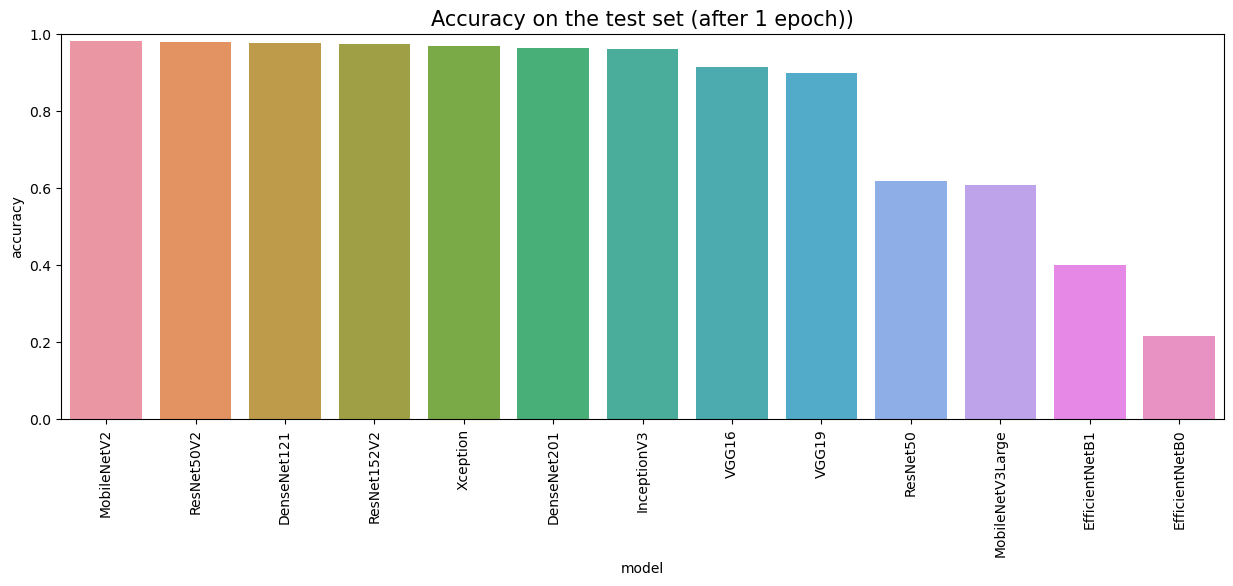

In [15]:
# 전이학습 모델 정확도 확인

plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

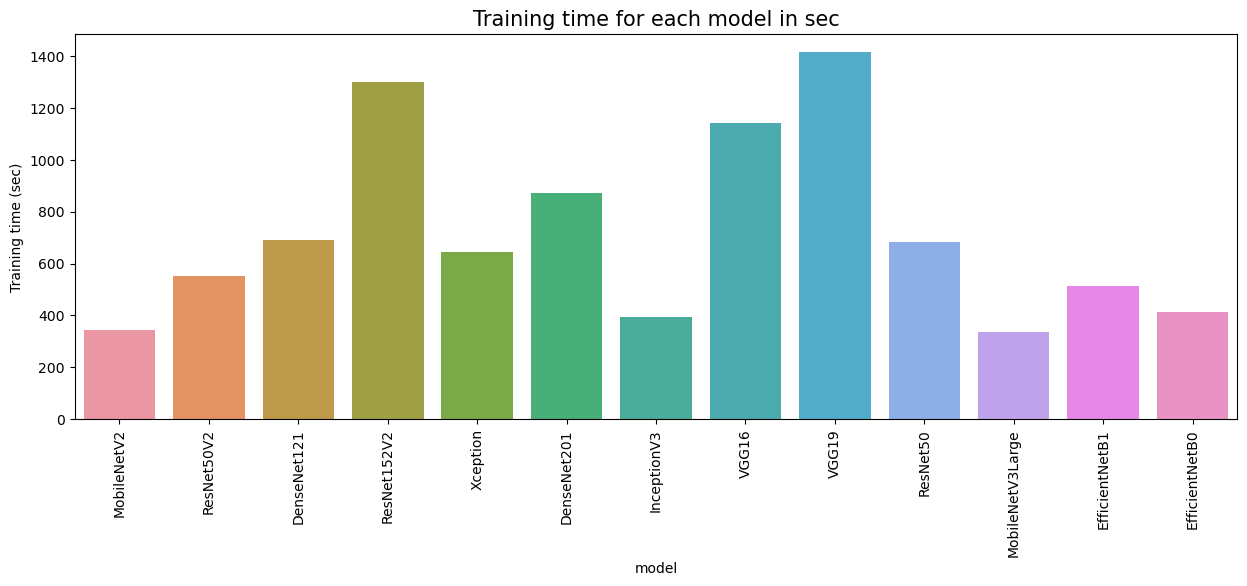

In [16]:
# 전이학습 모델 시간 확인

plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

# 모델 성능 확인 _ MobileNetV2, ResNet50V2

성능이 좋고, training time이 적게 걸리는 두 개의 모델 선정

## 좋은 효율을 내는 모델 성능확인 1 (MobileNetV2)

In [19]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 18064 validated image filenames belonging to 12 classes.
Found 2007 validated image filenames belonging to 12 classes.
Found 6144 validated image filenames belonging to 12 classes.
Epoch 1/5
565/565 [==============================] - 333s 585ms/step - loss: 0.1734 - accuracy: 0.9429 - val_loss: 0.0698 - val_accuracy: 0.9786
Epoch 2/5
565/565 [==============================] - 430s 761ms/step - loss: 0.0502 - accuracy: 0.9823 - val_loss: 0.0674 - val_accuracy: 0.9746
Epoch 3/5
565/565 [==============================] - 520s 921ms/step - loss: 0.0346 - accuracy: 0.9884 - val_loss: 0.0570 - val_accuracy: 0.9811
Epoch 4/5
565/565 [==============================] - 523s 925ms/step - loss: 0.0281 - accuracy: 0.9905 - val_loss: 0.0668 - val_accuracy: 0.9791
Epoch 5/5
565/565 [==============================] - 429s 758ms/step - loss: 0.0203 - accuracy: 0.9924 - val_loss: 0.0536 - val_accuracy: 0.9836


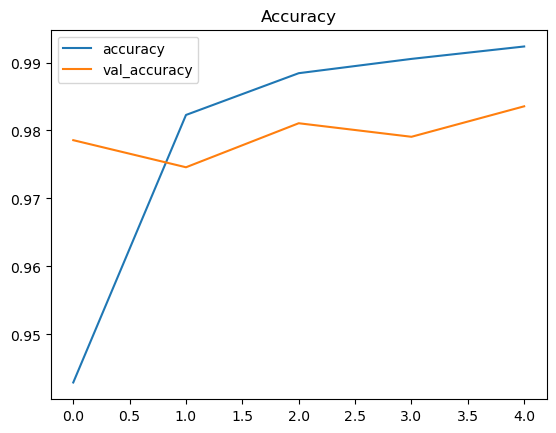

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

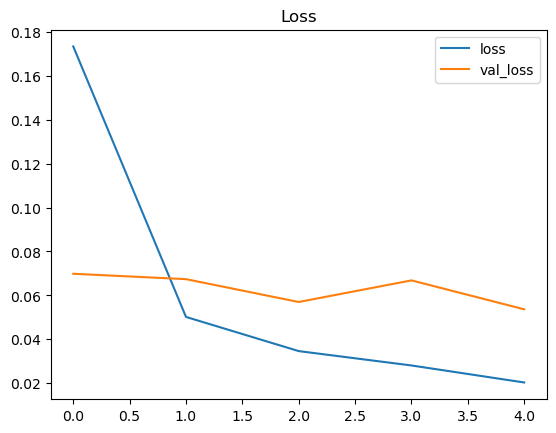

In [21]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

192/192 [==============================] - 103s 534ms/step
Accuracy on the test set: 98.49%


## 좋은 효율을 내는 모델 성능확인 2 (ResNet50V2)

In [24]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 18064 validated image filenames belonging to 12 classes.
Found 2007 validated image filenames belonging to 12 classes.
Found 6144 validated image filenames belonging to 12 classes.
Epoch 1/5
565/565 [==============================] - 555s 977ms/step - loss: 0.1771 - accuracy: 0.9433 - val_loss: 0.1530 - val_accuracy: 0.9527
Epoch 2/5
565/565 [==============================] - 563s 997ms/step - loss: 0.0500 - accuracy: 0.9842 - val_loss: 0.1057 - val_accuracy: 0.9656
Epoch 3/5
565/565 [==============================] - 607s 1s/step - loss: 0.0361 - accuracy: 0.9879 - val_loss: 0.0840 - val_accuracy: 0.9756
Epoch 4/5
565/565 [==============================] - 558s 988ms/step - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0845 - val_accuracy: 0.9781
Epoch 5/5
565/565 [==============================] - 541s 958ms/step - loss: 0.0194 - accuracy: 0.9934 - val_loss: 0.1041 - val_accuracy: 0.9761


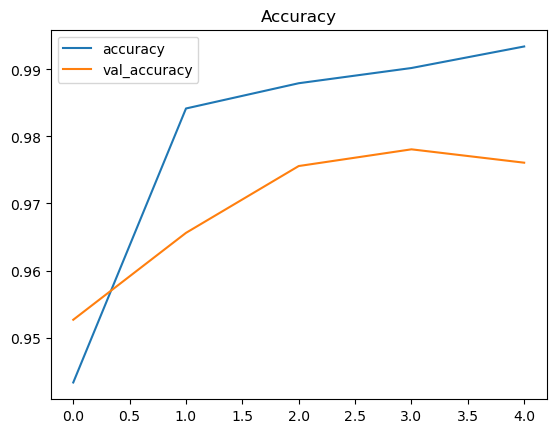

In [25]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

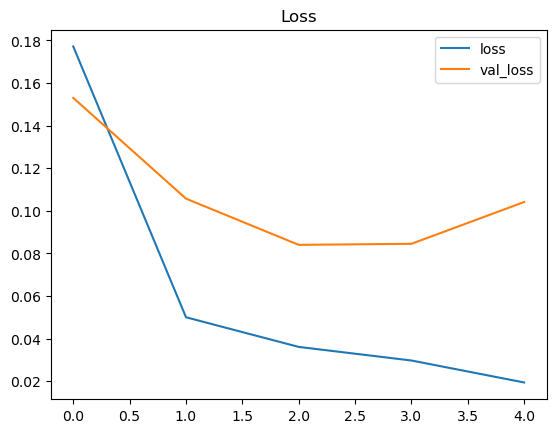

In [26]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

192/192 [==============================] - 196s 1s/step


# Accuracy on the test set: 98.54%

In [29]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                precision    recall  f1-score   support

   freshapples       1.00      0.99      0.99       791
   freshbanana       1.00      1.00      1.00       892
 freshcucumber       1.00      0.87      0.93       279
  freshoranges       0.99      0.99      0.99       388
   freshpotato       0.99      0.89      0.94       270
   freshtomato       1.00      1.00      1.00       255
  rottenapples       1.00      1.00      1.00       988
  rottenbanana       1.00      1.00      1.00       900
rottencucumber       0.87      0.99      0.92       255
 rottenoranges       0.98      0.99      0.99       403
  rottenpotato       0.92      0.99      0.96       370
  rottentomato       1.00      1.00      1.00       353

      accuracy                           0.99      6144
     macro avg       0.98      0.98      0.98      6144
  weighted avg       0.99      0.99      0.99      6144



## Confusion Matrix 시각화
* Confusion 매트릭스도 히트맵을 통해서 나타내 보았는데 본인외에 전부 어두운색으로

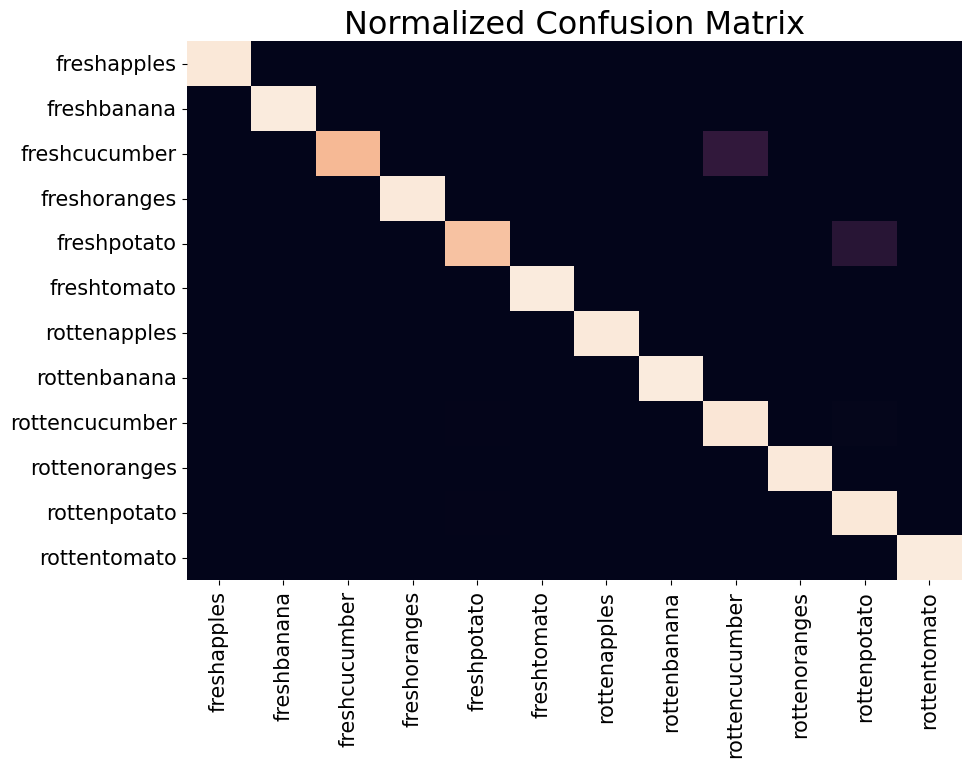

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 실전 : 모델 예측
* 모델을 실제로 확인해보기위해서 사진을 뽑아보고 그 사진에 대한 예측을 잘하는지 확인해보기

1/1 [==============================] - 0s 76ms/step


## 예측률 : 100.00%

### Class prediction = freshapples

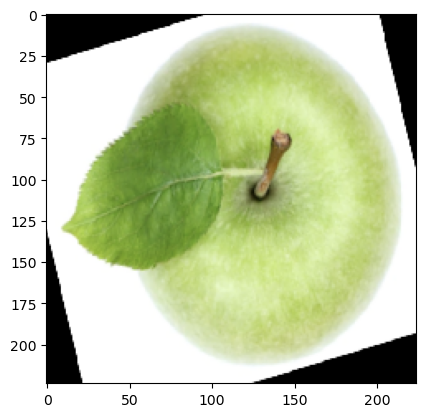

In [33]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
class_dictionary = {'freshapples' : 0, 'freshbanana' : 1, 'freshcucumber' : 2,
                    'freshoranges' : 3, 'freshpotato' : 4, 'freshtomato' : 5,
                    'rottenapples' : 6, 'rottenbanana' : 7, 'rottencucumber' : 8,
                    'rottenoranges' : 9,'rottenpotato' : 10, 'rottentomato' : 11 }

IMAGE_SIZE    = (224, 224)
given_num = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[given_num, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.)

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

* 여러 이미지 예측

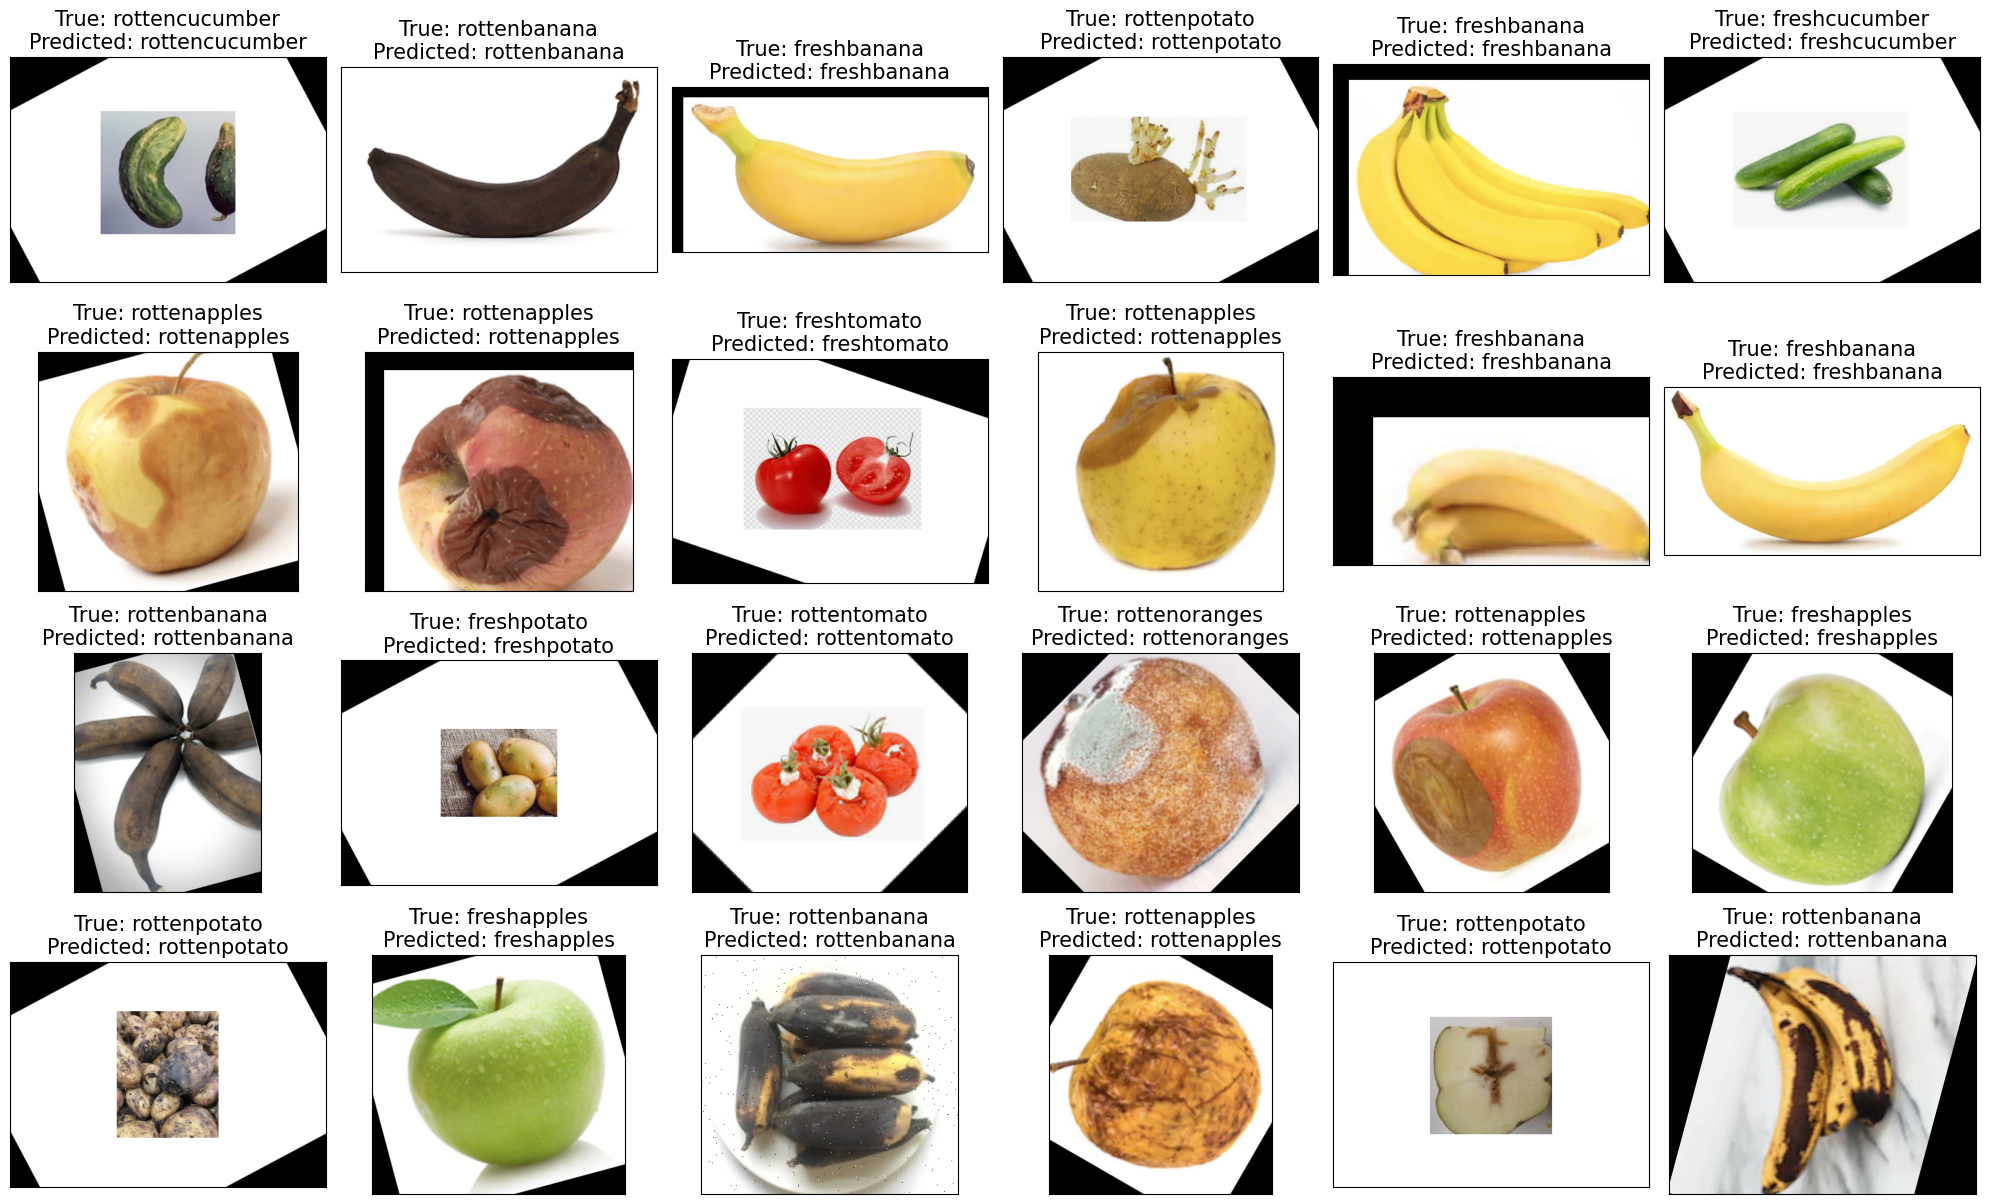

In [34]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [35]:
# 해당 모델을 안드로이드 어플에 넣어줄 파일로 변환시키기

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('class_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\sohtk\AppData\Local\Temp\tmpitfqed3z\assets


INFO:tensorflow:Assets written to: C:\Users\sohtk\AppData\Local\Temp\tmpitfqed3z\assets


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

interpreter = tf.lite.Interpreter(model_path="class_model.tflite")

interpreter.optimizations = [tf.lite.Optimize.DEFAULT]

lighter_class = interpreter.convert()

with open("lighter_class.tflite", "wb") as f:
    f.write(lighter_class)
    
# 원래 converter 쓸 때 양자화해줘야하는데, 안해줘서 나중에 interpreter로 사용하려고 했더니 되질 않음..

AttributeError: 'Interpreter' object has no attribute 'convert'

In [6]:
## update (23.07.23)
## 양자화가 안됐기 때문에 다시 모델 불러주고 학습 시작

from tensorflow.keras.models import load_model
cnn = load_model('cnn_model_1.h5')

In [7]:
## 앞에서 최종적으로 전이학습에 사용된 모델은 MobileNetV2와 Resnet50V2였기 때문에 두 모델만 불러와줌!

models = {
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

## 함수 내부에서는 전이 학습을 위해 사전 훈련된 모델을 로드하고, 추가적인 레이어를 연결하여 모델 구조를 정의
## 모델의 학습 가능한 가중치는 동결시키고, 컴파일 단계에서 옵티마이저, 손실 함수, 평가 지표를 설정.


def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs) # 모델마다 차례로 넣는다는 의미
    pretrained_model.trainable = False # 레이어를 동결시켜서 훈련 중 손실을 최소화
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
    # 라벨 개수가 12개이기 때문에 Dense도 12로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Found 18064 validated image filenames belonging to 12 classes.
Found 2007 validated image filenames belonging to 12 classes.
Found 6144 validated image filenames belonging to 12 classes.




In [8]:
# Train 모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

MobileNetV2          trained in 459.75 sec
ResNet50V2           trained in 812.26 sec


In [9]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

192/192 [==============================] - 177s 921ms/step
**MobileNetV2 has a 97.75% accuracy on the test set**
192/192 [==============================] - 258s 1s/step
**ResNet50V2 has a 97.31% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,MobileNetV2,0.9791,0.9775,459.75
1,ResNet50V2,0.9711,0.9731,812.26


In [10]:
# MobileNetV2부터!

train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 18064 validated image filenames belonging to 12 classes.
Found 2007 validated image filenames belonging to 12 classes.
Found 6144 validated image filenames belonging to 12 classes.
Epoch 1/5
565/565 [==============================] - 423s 745ms/step - loss: 0.1733 - accuracy: 0.9437 - val_loss: 0.0688 - val_accuracy: 0.9756
Epoch 2/5
565/565 [==============================] - 327s 578ms/step - loss: 0.0485 - accuracy: 0.9841 - val_loss: 0.0482 - val_accuracy: 0.9796
Epoch 3/5
565/565 [==============================] - 310s 548ms/step - loss: 0.0324 - accuracy: 0.9887 - val_loss: 0.0596 - val_accuracy: 0.9831
Epoch 4/5
565/565 [==============================] - 348s 616ms/step - loss: 0.0266 - accuracy: 0.9905 - val_loss: 0.0441 - val_accuracy: 0.9811
Epoch 5/5
565/565 [==============================] - 353s 624ms/step - loss: 0.0251 - accuracy: 0.9905 - val_loss: 0.0442 - val_accuracy: 0.9851


In [11]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

192/192 [==============================] - 96s 498ms/step
Accuracy on the test set: 99.15%


In [12]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                precision    recall  f1-score   support

   freshapples       0.99      1.00      0.99       791
   freshbanana       1.00      1.00      1.00       892
 freshcucumber       1.00      0.98      0.99       279
  freshoranges       1.00      1.00      1.00       388
   freshpotato       1.00      0.87      0.93       270
   freshtomato       1.00      1.00      1.00       255
  rottenapples       1.00      0.99      1.00       988
  rottenbanana       1.00      1.00      1.00       900
rottencucumber       0.98      1.00      0.99       255
 rottenoranges       1.00      0.99      1.00       403
  rottenpotato       0.91      1.00      0.95       370
  rottentomato       1.00      1.00      1.00       353

      accuracy                           0.99      6144
     macro avg       0.99      0.99      0.99      6144
  weighted avg       0.99      0.99      0.99      6144



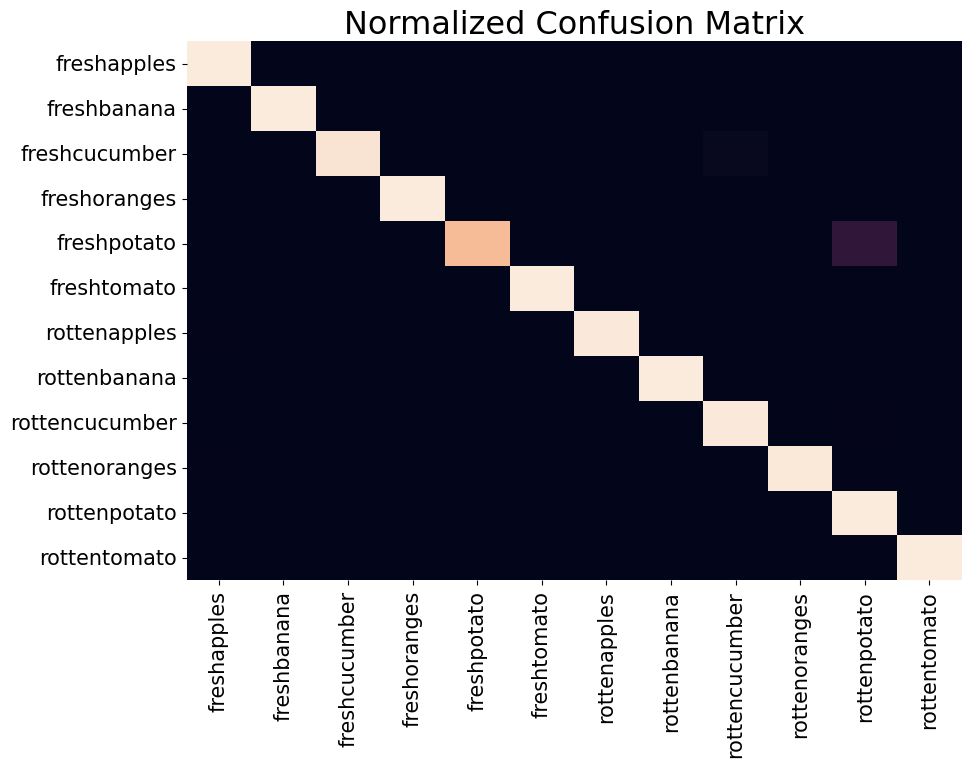

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

1/1 [==============================] - 0s 27ms/step


## 예측률 : 99.99%

### Class prediction = freshapples

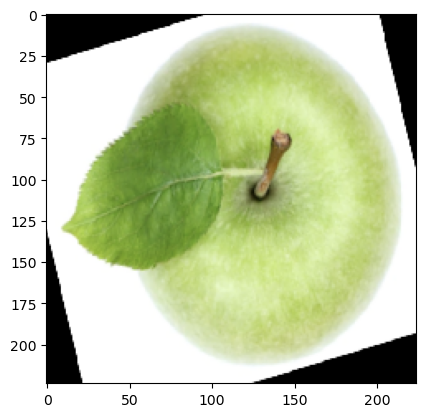

In [16]:
# 실전 예측

from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
class_dictionary = {'freshapples' : 0, 'freshbanana' : 1, 'freshcucumber' : 2,
                    'freshoranges' : 3, 'freshpotato' : 4, 'freshtomato' : 5,
                    'rottenapples' : 6, 'rottenbanana' : 7, 'rottencucumber' : 8,
                    'rottenoranges' : 9,'rottenpotato' : 10, 'rottentomato' : 11 }

IMAGE_SIZE    = (224, 224)
given_num = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[given_num, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.)

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

In [18]:
# 모델 먼저 저장!
save_newmodel_path = 'C:/Users/sohtk/OneDrive/desktop/2023summer/GURU2 Android/A_final_project/final_model.h5'
model.save(save_newmodel_path)
print("모델이 저장된 경로:", save_newmodel_path)

모델이 저장된 경로: C:/Users/sohtk/OneDrive/desktop/2023summer/GURU2 Android/A_final_project/final_model.h5


In [20]:
import tensorflow as tf
from keras.models import load_model

loaded = load_model("final_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(loaded)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

lite_model = converter.convert()

with open("lite_model_final.tflite", "wb") as f:
    f.write(lite_model)

INFO:tensorflow:Assets written to: C:\Users\sohtk\AppData\Local\Temp\tmp0mwrx_4_\assets


INFO:tensorflow:Assets written to: C:\Users\sohtk\AppData\Local\Temp\tmp0mwrx_4_\assets


In [1]:
import tensorflow as tf

# 모델 파일 경로 설정
model_path = "final_model.h5"

# 모델 불러오기
model = tf.keras.models.load_model(model_path)

# 입력 노드의 이름 확인
input_node_name = model.input.name
print("입력 노드의 이름:", input_node_name)


입력 노드의 이름: input_3


In [3]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           